<a href="https://colab.research.google.com/github/Dyl-cmyk/datascience/blob/Assignments-Due/Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

*Before*, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


###Task 1

**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

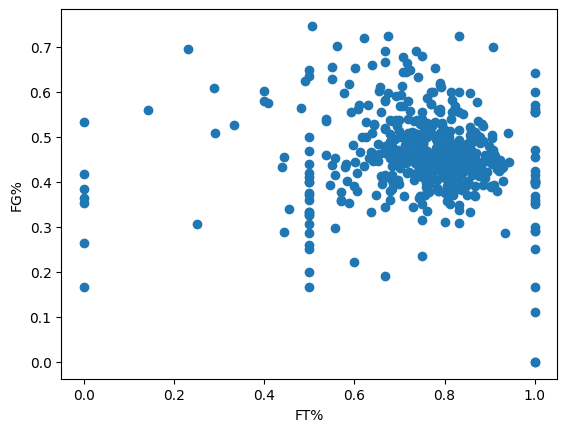

In [ ]:
plt.scatter(basketball['FT%'] , basketball['FG%'],)

plt.xlabel("FT%")
plt.ylabel("FG%")

The graph looks noticeabely different than the one seen in the notes with players at the o%, 50% and 100% marks notably. This affects my visual interpertations of the slope of the graph. These patterens are likley there due to people who do not get a lot of playing time and/or get fouled very rarely so their Ft numbers are likley 2-5 FTs attempted with none, half, or all of them made.

###Task 2

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [ ]:
pos_idx = basketball.Pos.cat.codes.values

pos_codes = basketball.Pos.cat.categories

bb_coords = {"pos": pos_codes}

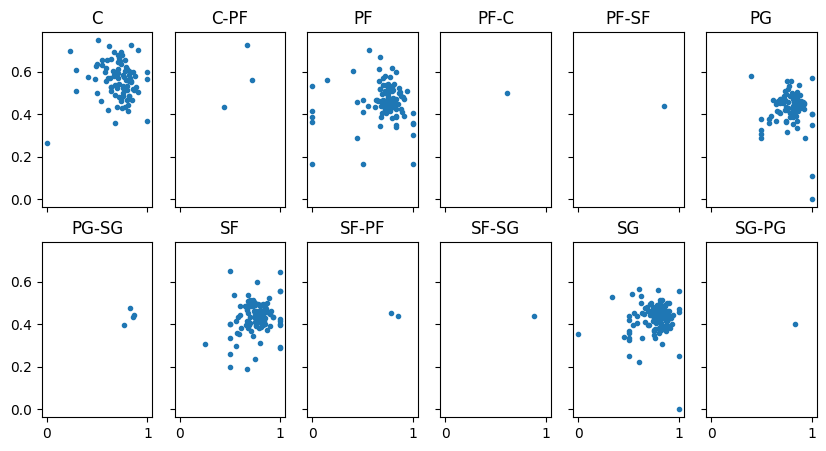

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

contrary to my perdiction this actually visually condensed the data due to the graphs having to change their scale compared to the Notes in order to fit the outliars into the data. The Center and Power Forward positions seem to be the most affected by this change (in addition to the Point Guard) by introducting several outliars around the 20% FG range

###Task 3

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

The linear regression model would likley not run due to the increase in outliars that would make the model "Mad" by introducting zero slopes and or data so bad that it could not figure out what to due with it. This is the fault of players who get 0%, or 100% FT or players who have never shot a FT (of which there would be some) as well as players (Like seen in the PG position who stack vertically at the 50% FT percentage and mess up the slopes of the graph

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [2]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [3]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


###Task 4

**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'Weight')

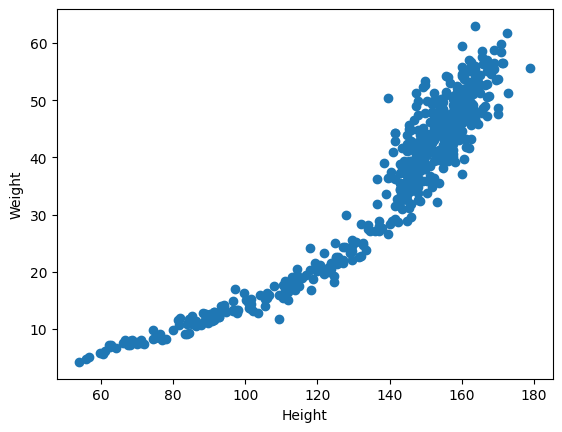

In [4]:
plt.scatter(howell['height'] , howell['weight'],)

#label axes
plt.xlabel("Height")
plt.ylabel("Weight")

###Task 5

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
#ANSWER6

#lba stands for linear babies
with pm.Model() as model_howell:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howell = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

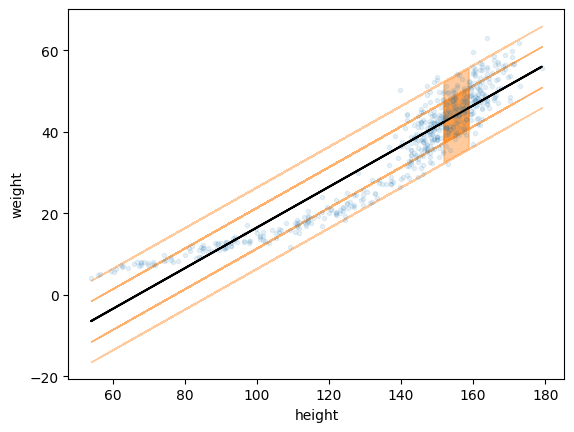

In [ ]:

_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_how = az.extract(idata_howell)

μ_m = posterior_how["μ"].mean("sample").values
σ_m = posterior_how["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

###Task 6

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:

pm.sample_posterior_predictive(
    idata_howell, model = model_howell, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

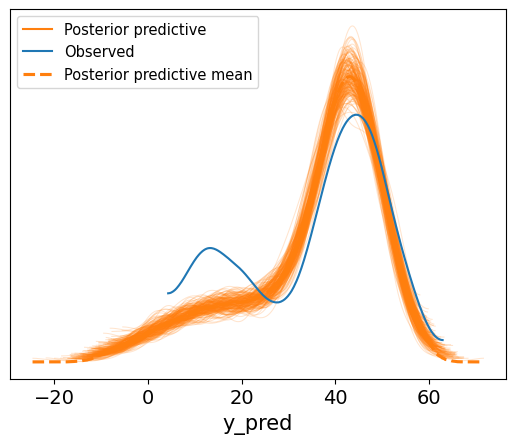

In [ ]:
az.plot_ppc(idata_howell, num_pp_samples=200, colors=["C1", "C0", "C1"])

The Fit is decent...Id for sure use it as a solid start, but i would not say it is something i would use for actual data analysis

###Task 7

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [5]:
with pm.Model() as model_exphow:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", pm.math.sinh(α + β * howell.height))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howexp = pm.sample(target_accept=.96)

Output()

Output()

In [6]:

#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_howexp, model = model_exphow, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

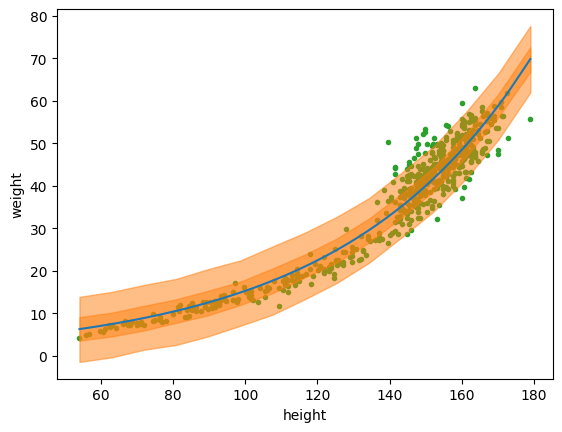

In [7]:

mean_line = idata_howexp.posterior["μ"].mean(("chain", "draw"))
height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(), 15)
y_pred_q = idata_howexp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")

###Task 8

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

<Axes: xlabel='y_pred'>

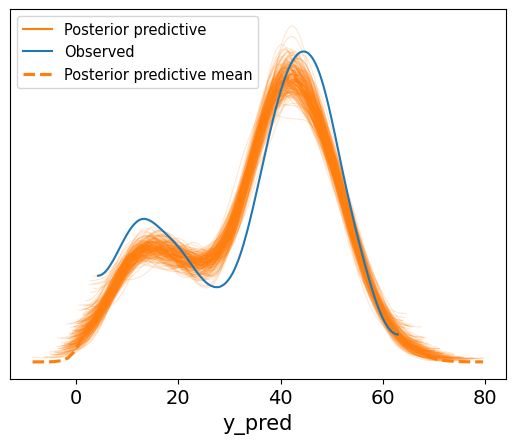

In [8]:
az.plot_ppc(idata_howexp, num_pp_samples=200, colors=["C1", "C0", "C1"])

The PPC looks pretty Good! Fit seems to be consistently off, so a simple adjustment could be made to line it up. But overall its a good model!

I would use it for sure